In [29]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import scipy
import librosa
from torch import nn
from scipy.signal import stft
import sounddevice as sd

In [30]:
duration = 5  # 초
sampling_rate = 44100
print("Recording...")
audio_data = sd.rec(int(duration * sampling_rate), samplerate=sampling_rate, channels=1, dtype='float32')
sd.wait()
sf.write("recorded_audio.wav", audio_data, sampling_rate)
print("Recording saved.")

Recording...
Recording saved.


In [31]:
# 모델 정의 (CNN+Transformer)
class CNNTransformer(nn.Module):
    def __init__(self, input_size=257, num_classes=1):
        super(CNNTransformer, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(128, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=32, nhead=2)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=1)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(2, 0, 1)
        x = self.transformer(x)
        x = x.mean(dim=0)
        x = self.fc(x)
        return x

In [32]:
# 모델 불러오기
model = CNNTransformer(input_size=257, num_classes=1)
model.load_state_dict(torch.load("cnn_transformer_model.pth"))
model.eval()

/var/folders/d4/t8h5srt10_58wj8kmzzdyqq40000gn/T/ipykernel_59741/1913863380.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_transfo

CNNTransformer(
  (cnn): Sequential(
    (0): Conv1d(257, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (transformer_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (linear1): Linear(in_features=32, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=32, bias=True)
    (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transfo

In [33]:
# Fourier Transform 함수
def perform_fourier_transform(audio_data):
    _, _, freq_data = stft(audio_data, fs=sampling_rate, window='rectangular', nperseg=512, noverlap=0, nfft=512)
    magnitude = np.abs(freq_data)
    return magnitude

In [65]:
# WAV 파일을 사용한 판단 함수
def process_audio_file(file_path):
    print(f"Loading audio file: {file_path}")
    audio_data, sr = sf.read(file_path)
    if sr != sampling_rate:
        audio_data = librosa.resample(audio_data, orig_sr=sr, target_sr=sampling_rate)

    # Fourier Transform 및 데이터 변환
    magnitude = perform_fourier_transform(audio_data)
    magnitude = magnitude.T  # Transpose to match (time_frames, frequency_bins)
    input_data = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(0).permute(0, 2, 1)  # (batch_size, channels, sequence_length)

    with torch.no_grad():
        output = model(input_data)
        prediction = torch.sigmoid(output).item()

    # 예측 결과 시각화
    plt.figure(figsize=(10, 6))

    # 오디오 신호 플롯
    plt.subplot(2, 1, 1)
    plt.plot(audio_data[:sampling_rate])
    plt.title("Audio Signal")
    plt.xlim(0, len(audio_data))
    plt.ylim(-1, 1)

    # 예측 결과 출력
    plt.subplot(2, 1, 2)
    plt.title("Prediction Result")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Loading audio file: /Users/iuseong/Downloads/Record/screaming001.wav


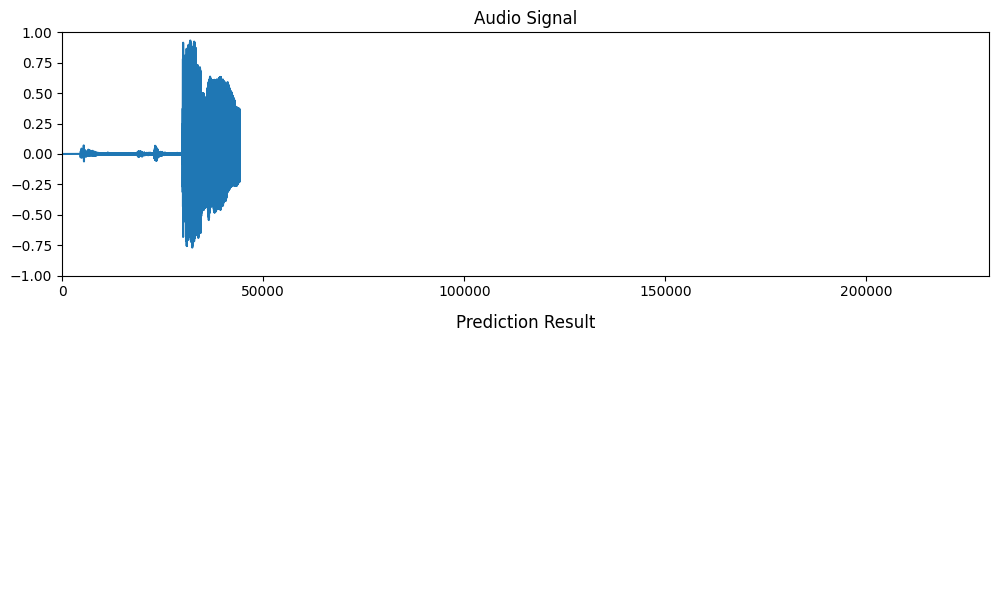

In [66]:
# 메인 함수 실행
if __name__ == "__main__":
    file_path = "/Users/iuseong/Downloads/Record/screaming001.wav"
    process_audio_file(file_path)